# 1 Keypoint Moseq Model Training

*Anusha Aggarwal*

### Imports

In [1]:
import keypoint_moseq as kpms
import matplotlib.pyplot as plt
import numpy as np
#from jax_moseq.utils import set_mixed_map_iters
#set_mixed_map_iters(4)

Check if Jax has access to the GPU

In [2]:
import jax

print(jax.default_backend())

gpu


### Project Setup

Set up the project using a sample file (representative of the other data files).

In [3]:
import h5py
for name in h5py.File('./video_dir/Trial3_BesC0_066_unfiltered.h5', 'r'):
    print(name)

edge_inds
edge_names
instance_scores
labels_path
node_names
point_scores
provenance
track_names
track_occupancy
tracking_scores
tracks
video_ind
video_path


In [4]:
import h5py
with h5py.File('./video_dir/Trial3_BesC0_066_unfiltered.h5', "r") as f:
    print(f["tracks"][()].shape)
    print(f["point_scores"][()].shape)

(17, 2, 17, 72000)
(17, 17, 72000)


In [5]:
project_dir = 'anusha_kpms_project'
config = lambda: kpms.load_config(project_dir)

In [ ]:
sleap_file = './video_dir/Trial3_BesC0_066_unfiltered.h5' # any .slp or .h5 file with predictions for a single video
kpms.setup_project(project_dir, sleap_file=sleap_file)

Update the config file by setting the directory of the other sample videos, assigning anterior & posterior body parts, and updating the list of body parts we actually want to use for modeling.

Keep all the bodyparts.

In [ ]:
kpms.update_config(
    project_dir,
    video_dir='/Genomics/argo/users/aa8417/anusha_kpms_trial/video_dir',
    anterior_bodyparts=['head','antenna_l','antenna_r','antenna_l_joint','antenna_r_joint'],
    posterior_bodyparts=['abdomen'],
    use_bodyparts=['tag','head','thorax_a','abdomen','antenna_l','antenna_r','foreleg_l','foreleg_r','midleg_l','midleg_r','hindleg_l',
                   'hindleg_r','wing_l','wing_r','thorax_h','antenna_l_joint','antenna_r_joint'])

Keep everything except tag, midlegs, and wings.

In [ ]:
kpms.update_config(
    project_dir,
    video_dir='/Genomics/argo/users/aa8417/anusha_kpms_trial/video_dir',
    anterior_bodyparts=['head','antenna_l','antenna_r','antenna_l_joint','antenna_r_joint'],
    posterior_bodyparts=['abdomen'],
    use_bodyparts=['head','thorax_a','abdomen','antenna_l','antenna_r','foreleg_l','foreleg_r','hindleg_l',
                   'hindleg_r','thorax_h','antenna_l_joint','antenna_r_joint'])

Adjust the kappa value for model initialization (after fitting model with default parameters - 1e6).

In [ ]:
kpms.update_config(project_dir, kappa=1e5)

Load in the rest of the data.

In [ ]:
# load data (e.g. from SLEAP)}
keypoint_data_path = './video_dir/' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'sleap')

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

### Noise Calibration

In [ ]:
kpms.noise_calibration(project_dir, coordinates, confidences, **config())

### Fit PCA

PCA needs to be rerun if you change use_bodyparts in the config file.

In [ ]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

In [ ]:
# use the following to load an already fit model
pca = kpms.load_pca(project_dir)

Update the config based on how many components are needed to explain 90% of the variation in the data; how many dimensions preserve the patterns/trends we see in the keypoint data.

In [ ]:
kpms.update_config(project_dir, latent_dim=4)

### Model Fitting

#### Initialization

In [ ]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

#### Fitting an AR-HMM

In [ ]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

#### Fitting the Full Model

Getting memory errors, so setting parallel messaging passing as false for now. Will slow down computation, but not by that much.

In [ ]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 200 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, parallel_message_passing=False, ar_only=False, 
    start_iter=current_iter, num_iters=current_iter+500)[0]

#### Sort Syllables by Frequency

In [ ]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

#### Extract Model Results

In [ ]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

#### Save Results to .csv

In [ ]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

#### Apply to New Data

This will fit the existing syllables to the new data. It will not re-train the model. The "Continue Model Fitting with New Data" will refit the model with the new data.

project_dir = 'anusha_kpms_project'
model_name = 'gpu_1e5'

# load the most recent model checkpoint and pca object
model = kpms.load_checkpoint(project_dir, model_name)[0]
pca = kpms.load_pca(project_dir)

# load new data
new_data = 'anusha_kpms_trial/new_videos_queenless' # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'sleap')
data, metadata = kpms.format_data(coordinates, confidences, **config())

# apply saved model to new data
results = kpms.apply_model(model, pca, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name)

### Visualization

#### Trajectory Plots

In [ ]:
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

#### Grid Movies

In [ ]:
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

#### Syllable Dendrogram

Uses complete linkage clustering.

In [ ]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())

#### Automatic Kappa Scan

In [ ]:
kappas = np.logspace(3,7,5)
prefix = 'my_kappa_scan'

for kappa in kappas:
    print(f"Fitting model with kappa={kappa}")
    model = kpms.update_hypparams(model, kappa=kappa)
    model_name = f'{prefix}-{kappa}'

    kpms.fit_model(
        model, data, metadata, project_dir,
        model_name, ar_only=True, num_iters=100,
        save_every_n_iters=25)

kpms.plot_kappa_scan(kappas, project_dir, prefix)

#### Continue Model Fitting but with New Data

Will refit the model with new data. Only new videos will be included in downstream analysis though, so if you want the original videos as well, you should add them to the new video directory.

Loading keypoints: 100%|██████████████████| 3/3 [00:15<00:00,  5.26s/it]


Outputs will be saved to anusha_kpms_project/2023_12_12-22_03_13


 12%|████▏                             | 25/201 [04:29<28:58,  9.88s/it]

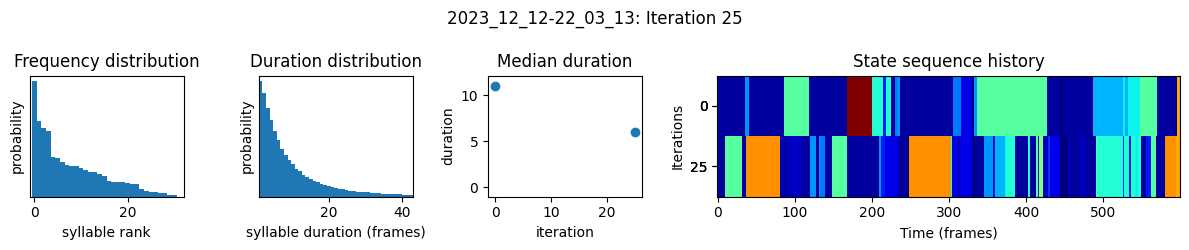

 25%|████████▍                         | 50/201 [08:32<23:49,  9.47s/it]

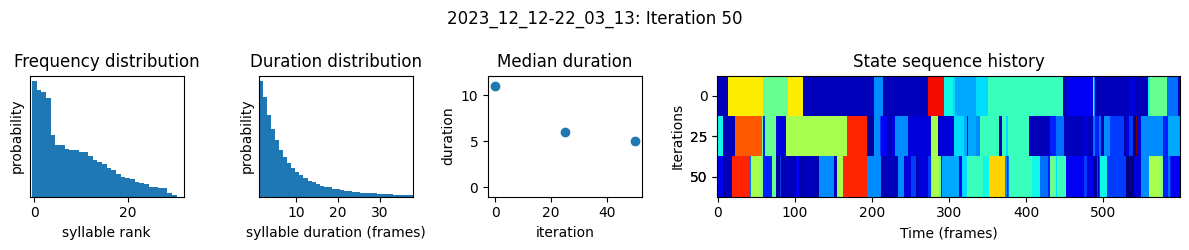

 37%|████████████▋                     | 75/201 [12:39<19:56,  9.50s/it]

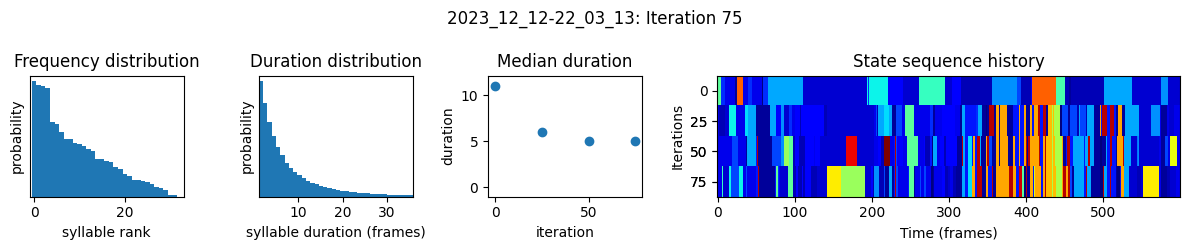

 50%|████████████████▍                | 100/201 [16:43<15:56,  9.47s/it]

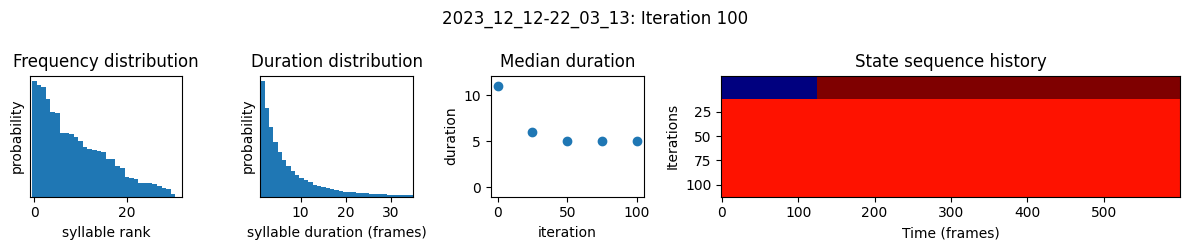

 62%|████████████████████▌            | 125/201 [20:50<11:59,  9.47s/it]

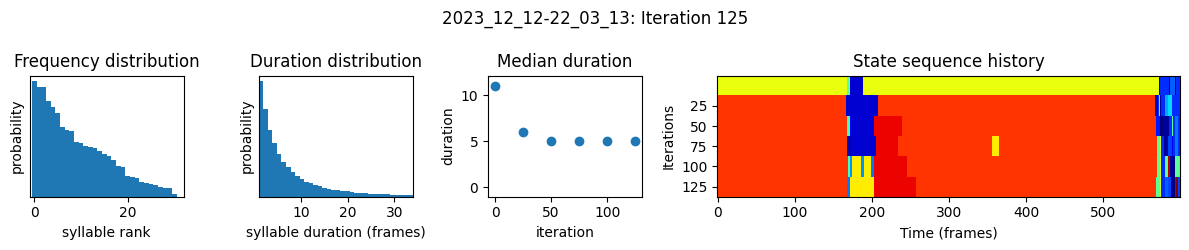

 75%|████████████████████████▋        | 150/201 [24:57<08:04,  9.50s/it]

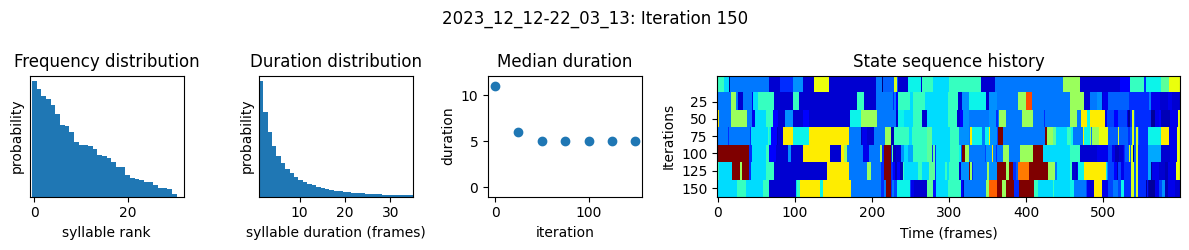

 87%|████████████████████████████▋    | 175/201 [29:00<04:04,  9.41s/it]

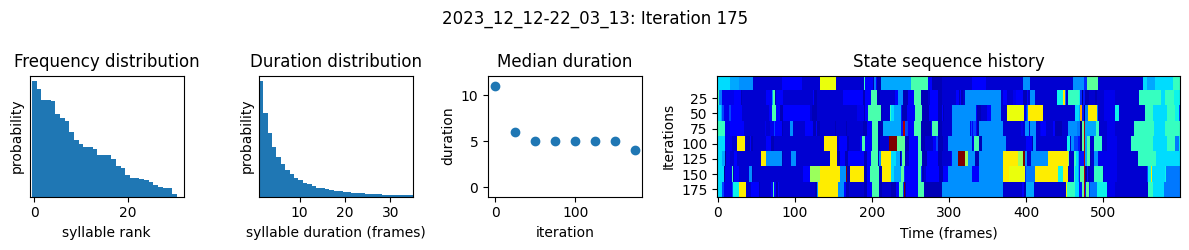

100%|████████████████████████████████▊| 200/201 [33:09<00:09,  9.40s/it]

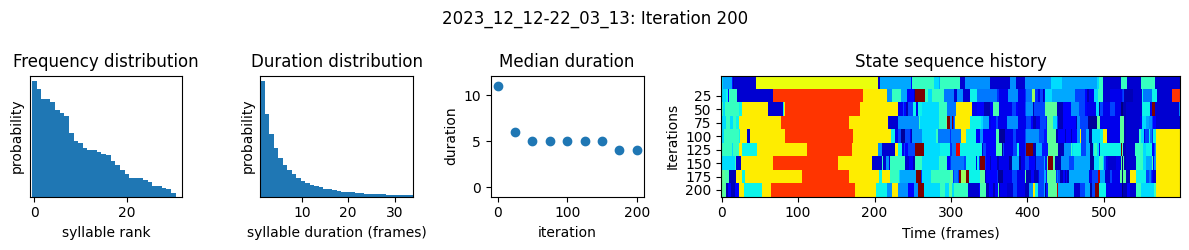

100%|█████████████████████████████████| 201/201 [33:26<00:00,  9.98s/it]


In [6]:
project_dir = 'anusha_kpms_project'
config = lambda: kpms.load_config(project_dir)
model_name = 'gpu_1e5'

kpms.update_config(project_dir, kappa=1e5)

# load and format new data (e.g. from DeepLabCut)
new_data = 'new_videos_queenless' # can be a file, a directory, or a list of files
coordinates, confidences,bodyparts = kpms.load_keypoints(new_data, 'sleap')
data, metadata = kpms.format_data(coordinates, confidences, **config())

# load previously saved PCA and model checkpoint
pca = kpms.load_pca(project_dir)
model = kpms.load_checkpoint(project_dir, model_name)[0]

# initialize a new model using saved parameters
model = kpms.init_model(
   data, pca=pca, params=model['params'],
   hypparams=model['hypparams'], **config())

model = kpms.update_hypparams(model, kappa=1e4)

# continue fitting, now with the new data
model, model_name = kpms.fit_model(
   model, data, metadata, project_dir, parallel_message_passing=False, ar_only=False, num_iters=200)

All other downstream tasks.

Reindexing: 100%|█████████████| 9/9 [01:27<00:00,  9.67s/model snapshot]


Saved results to anusha_kpms_project/2023_12_12-22_03_13/results.h5


Saving to csv: 100%|████████████████████| 49/49 [00:14<00:00,  3.32it/s]


Saving trajectory plots to anusha_kpms_project/2023_12_12-22_03_13/trajectory_plots


Generating trajectory plots: 100%|██████| 30/30 [00:17<00:00,  1.69it/s]


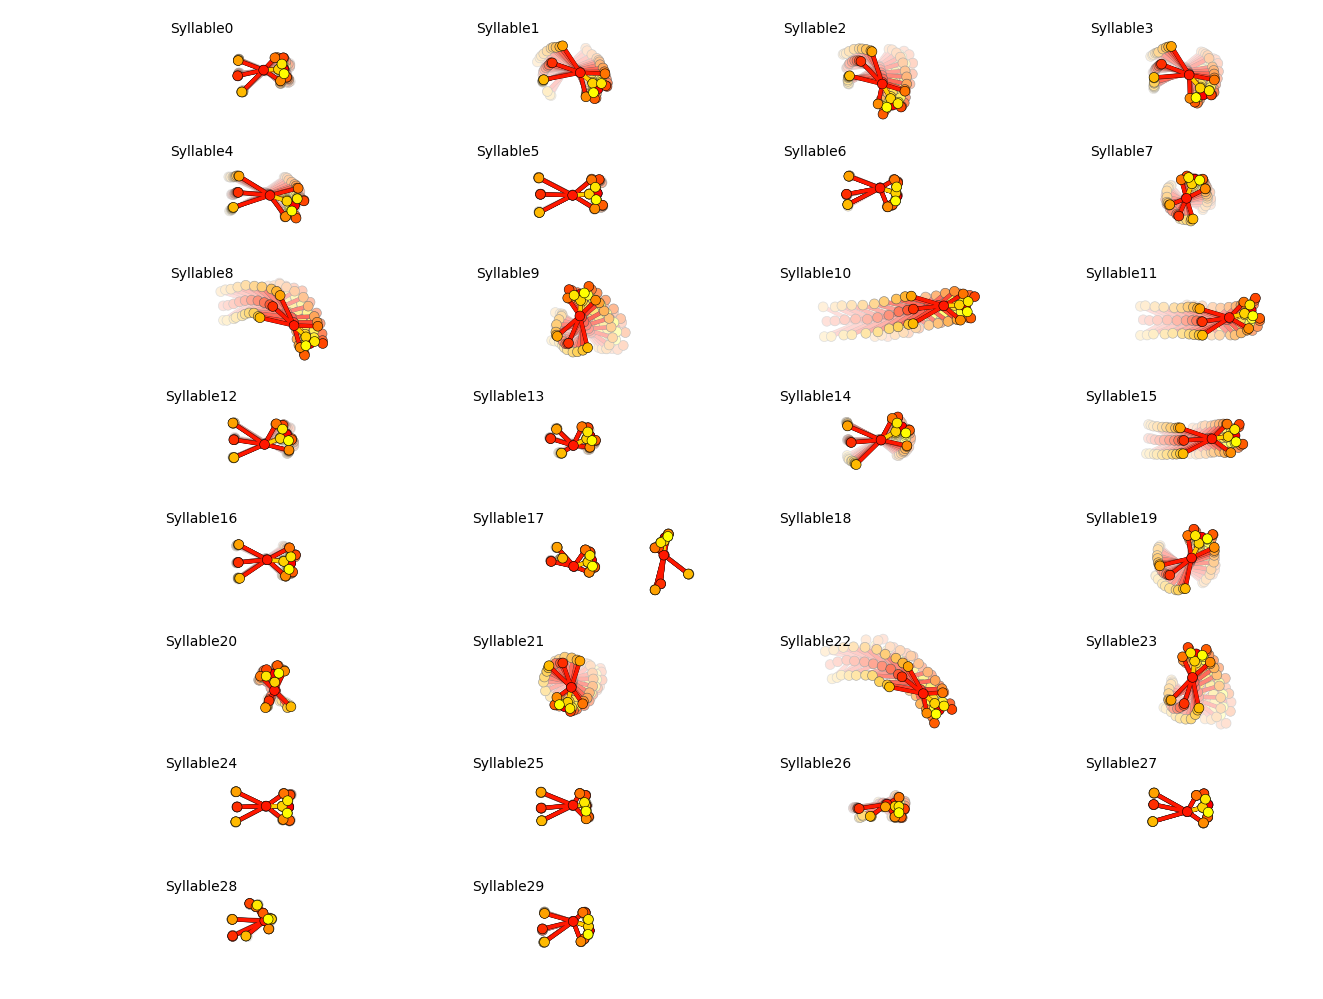

Saving dendrogram plot to anusha_kpms_project/2023_12_12-22_03_13/similarity_dendrogram


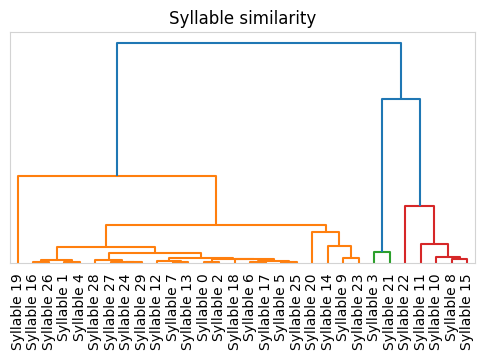

In [7]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

# generate trajectory plots
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

# generate grid movies -- might have some issues with video name and h5 file name
# kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config())

# generate syllable dendrogram
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())